Data Source
-----------
U.S. Energy Information Administration, Crude Oil Prices: Brent - Europe [DCOILBRENTEU], retrieved from FRED, Federal Reserve Bank of St. Louis; /home2/git-repos/iiot-analytics/dev/borodastov/training/Cursera/Applied_AI_with_DL_IBM/DCOILBRENTEU.csv, November 11, 2020.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import load_model
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.models import Model
import h5py

In [21]:
df_data_1 = pd.read_csv('DCOILBRENTEU.csv')
print(df_data_1.shape)
df_data_1.head()

(8729, 2)


,DATE,DCOILBRENTEU
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


#### 1. Preprocessing

#### Date

In [22]:
df_data_1.DATE = pd.to_datetime(df_data_1.DATE, infer_datetime_format=True)

#### Value

In [23]:
err = {}

for el in df_data_1.DCOILBRENTEU:
    try:
        float(el)
    except Exception as e:
        err[el] = e
err

{'.': ValueError("could not convert string to float: '.'")}

In [24]:
df_data_1[df_data_1.DCOILBRENTEU == '.']

,DATE,DCOILBRENTEU
18,1987-06-15,.
157,1987-12-25,.
162,1988-01-01,.
166,1988-01-07,.
179,1988-01-26,.
...,...,...
8582,2020-04-10,.
8583,2020-04-13,.
8602,2020-05-08,.
8613,2020-05-25,.


In [25]:
df_data_1 = df_data_1[df_data_1.DCOILBRENTEU != '.']
df_data_1.DCOILBRENTEU = df_data_1.DCOILBRENTEU.astype('float')
df_data_1 = df_data_1.set_index('DATE')
df_data_1.shape

(8494, 1)

#### 2. Visualization

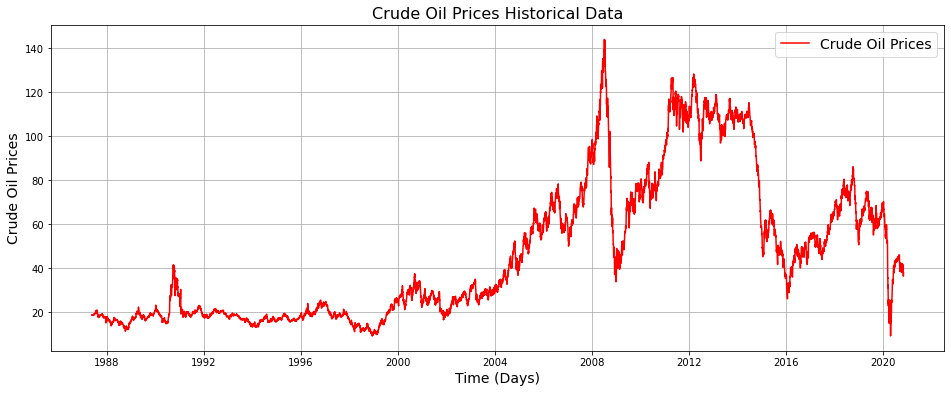

In [26]:
plt.figure(figsize=(16,6))
plt.plot(df_data_1, color = 'red', label = 'Crude Oil Prices')
plt.title('Crude Oil Prices Historical Data', fontsize=16)
plt.xlabel('Time (Days)', fontsize=14)
plt.ylabel('Crude Oil Prices', fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

#### 3. LSTM

- tensorflow should be > 2.2 for using keras

In [27]:
tf.__version__

'2.3.1'

#### Batch-size and trainings-set size

- use Stateful LSTM -> train_set % batch_size should be equal 0
- use Stateful LSTM -> test_set % batch_size should be equal 0

In [28]:
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    print('Original len:',length)
    length *= 1 - test_percent
    print('Slice for train upper limit:',int(length))
    print('batch size:',batch_size)
    train_length_values = []
    print(f'Searching for the max len divded on batch w/o remainder in interval [{int(length) - 100} - {int(length)}]')
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
#             print(x)
    return (max(train_length_values))

def get_test_length(dataset, batch_size, upper_train):
    length = len(dataset)
    print('Original len:',length)
    print('Upper train:',upper_train)
    test_length_values = []
    
    print(f'Searching for the max len divded on batch w/o remainder in interval [{length - 200} - {length - timesteps*2}]')
    print('low limit for interval is calculated as length - 200')
    print('upper limit for interval is calculated as length - timesteps*2')
    print('test length is calculated as (max len - upper train) / batch_size')
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
#             print(x)
    return (max(test_length_values))

#### Train, test preporation

In [29]:
df_data_1.shape

(8494, 1)

#### Train

Must consider:

- batch_size
- timestamps

#### batch_size

In [30]:
batch_size = 64
length = get_train_length(df_data_1, batch_size, 0.1)
print('max len:',length)

Original len: 8494
Slice for train upper limit: 7644
batch size: 64
Searching for the max len divded on batch w/o remainder in interval [7544 - 7644]
max len: 7616


#### timestamps

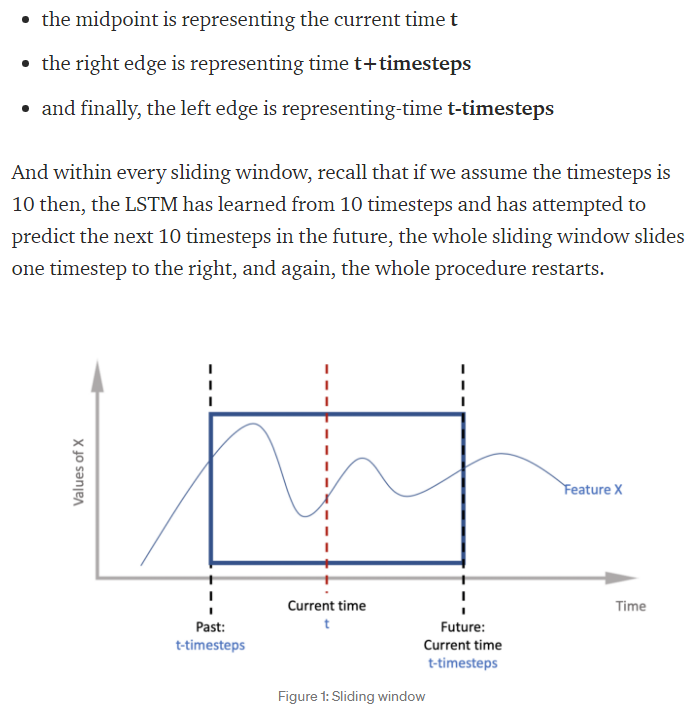

In [31]:
Image('/home2/git-repos/iiot-analytics/dev/borodastov/training/Cursera/Applied_AI_with_DL_IBM/timestamp_definition.png',
     width=600, height=600)

#### ! take 2 * timestamps for getting upper limit

In [33]:
batch_size = 64
timesteps = 10

train_length = length
print('max train length:',train_length)

upper_train = train_length + timesteps*2
print('take upper limit adding 2*ts:',upper_train)

df_data_1_train = df_data_1[0:upper_train]

#to numpy
train_set = df_data_1_train.iloc[:,[0]].values
print('train set shape:',train_set.shape)

max train length: 7616
take upper limit adding 2*ts: 7636
train set shape: (7636, 1)


#### Test

In [34]:
test_length = get_test_length(df_data_1, batch_size, upper_train)
print('max len:', test_length)

Original len: 8494
Upper train: 7636
Searching for the max len divded on batch w/o remainder in interval [8294 - 8474]
low limit for interval is calculated as length - 200
upper limit for interval is calculated as length - timesteps*2
test length is calculated as (max len - upper train) / batch_size
max len: 8468


In [35]:
batch_size = 64
timesteps = 10

print('max test length:',test_length)

upper_test = test_length + timesteps*2
print('take upper limit adding 2*ts:',upper_test)

df_data_1_test = df_data_1[upper_train:upper_test] 
test_set = df_data_1_test.iloc[:,[0]].values
print('test set shape:',test_set.shape)

max test length: 8468
take upper limit adding 2*ts: 8488
test set shape: (852, 1)


#### For attention

#### 1 vector

In [36]:
print(df_data_1.iloc[:,0].values.shape)
df_data_1.iloc[:,0].values

(8494,)


array([18.63, 18.45, 18.55, ..., 36.56, 36.33, 37.78])

#### 8494 vectors with shape 1

In [37]:
print(df_data_1.iloc[:,[0]].values.shape)
df_data_1.iloc[:,[0]].values

(8494, 1)


array([[18.63],
       [18.45],
       [18.55],
       ...,
       [36.56],
       [36.33],
       [37.78]])

#### Scaling

In [38]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(np.float64(train_set))
testing_set_scaled = sc.fit_transform(np.float64(test_set))
print(training_set_scaled.shape)
print(testing_set_scaled.shape)

(7636, 1)
(852, 1)


#### Deviding on features and targets sets

#### Train

In [39]:
print('max train length:',train_length)
print('take upper limit adding 2*ts:',upper_train)
print('train len:', training_set_scaled.shape[0])

max train length: 7616
take upper limit adding 2*ts: 7636
train len: 7636


In [21]:
X_train_len = train_length
print(f'X_train and y_train len = {X_train_len}')

X_train and y_train len = 7616


In [40]:
X_train = []
y_train = []

print(f'for X_train we should consider interval from {0} till {train_length + timesteps-1-1}')
print(f'for y_train we should consider interval from {timesteps} till {train_length+2*timesteps-1-1}')

for i in range(timesteps, train_length + timesteps):
    
    X_train.append(training_set_scaled[i-timesteps:i,0])
#     print(i-timesteps,i-1)
    y_train.append(training_set_scaled[i:i+timesteps,0])
#     print(i,i+timesteps-1)
    
max_i_in_range = max(range(timesteps, train_length + timesteps))
print('max i in range:',max_i_in_range)
print(f'last X_train slice between {max_i_in_range-timesteps} and {max_i_in_range-1}')
print(f'last y_train slice between {max_i_in_range} and {max_i_in_range+timesteps-1}')
print('X_train len',len(X_train))
print('X_train len',len(y_train))

for X_train we should consider interval from 0 till 7624
for y_train we should consider interval from 10 till 7634
max i in range: 7625
last X_train slice between 7615 and 7624
last y_train slice between 7625 and 7634
X_train len 7616
X_train len 7616


#### Test

In [41]:
print('max test length:',test_length)
print('take upper limit adding 2*ts:',upper_test)
print('test len:', testing_set_scaled.shape[0])

max test length: 8468
take upper limit adding 2*ts: 8488
test len: 852


In [42]:
X_test_len = test_length - upper_train
print(f'X_test and y_test len = {X_test_len}')

X_test and y_test len = 832


In [43]:
X_test = []
y_test = []

print(f'for X_test we should consider interval from {0} till {X_test_len + timesteps-1-1}')
print(f'for y_test we should consider interval from {timesteps} till {X_test_len+2*timesteps-1-1}')

for i in range(timesteps, X_test_len + timesteps):
    
    X_test.append(testing_set_scaled[i-timesteps:i,0])
#     print(i-timesteps,i-1)
    y_test.append(testing_set_scaled[i:i+timesteps,0])
#     print(i,i+timesteps-1)
    
max_i_in_range = max(range(timesteps, X_test_len + timesteps))
print('max i in range:',max_i_in_range)
print(f'last X_test slice between {max_i_in_range-timesteps} and {max_i_in_range-1}')
print(f'last y_test slice between {max_i_in_range} and {max_i_in_range+timesteps-1}')
print('X_test len',len(X_test))
print('X_test len',len(y_test))

for X_test we should consider interval from 0 till 840
for y_test we should consider interval from 10 till 850
max i in range: 841
last X_test slice between 831 and 840
last y_test slice between 841 and 850
X_test len 832
X_test len 832


#### Reshaping

In [44]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)


X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 1))
print(X_test.shape)
print(y_test.shape)

(7616, 10, 1)
(7616, 10, 1)
(832, 10, 1)
(832, 10, 1)


#### Building LSTM

In [45]:
# Initialising the LSTM Model with MAE Loss-Function
# Using Functional API

inputs_1_mae = Input(batch_shape=(batch_size,timesteps,1))
#each layer is the input of the next layer
lstm_1_mae = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mae)
lstm_2_mae = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mae)

output_1_mae = Dense(units = 1)(lstm_2_mae)

regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)

#adam is fast starting off and then gets slower and more precise
#mae -> mean absolute error loss function
regressor_mae.compile(optimizer='adam', loss = 'mae', metrics=['mae'])
regressor_mae.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 10, 1)]             0         
_________________________________________________________________
lstm (LSTM)                  (64, 10, 10)              480       
_________________________________________________________________
lstm_1 (LSTM)                (64, 10, 10)              840       
_________________________________________________________________
dense (Dense)                (64, 10, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


#### Fitting model

In [31]:
%%time
epochs = 120

#Statefull
for i in range(epochs):
    print("Epoch: " + str(i))
    #run through all data but the cell, hidden state are used for the next batch.
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size,
                        validation_data=(X_test,y_test))
    #resets only the states but the weights, cell and hidden are kept.
    regressor_mae.reset_states()

Epoch: 0
119/119 [==============================] - 1s 9ms/step - loss: 0.0441 - mae: 0.0441 - val_loss: 0.2464 - val_mae: 0.2464
Epoch: 1
119/119 [==============================] - 1s 5ms/step - loss: 0.0454 - mae: 0.0454 - val_loss: 0.2199 - val_mae: 0.2199
Epoch: 2
119/119 [==============================] - 1s 5ms/step - loss: 0.0521 - mae: 0.0521 - val_loss: 0.1788 - val_mae: 0.1788
Epoch: 3
119/119 [==============================] - 1s 5ms/step - loss: 0.0565 - mae: 0.0565 - val_loss: 0.1534 - val_mae: 0.1534
Epoch: 4
119/119 [==============================] - 1s 5ms/step - loss: 0.0586 - mae: 0.0586 - val_loss: 0.1461 - val_mae: 0.1461
Epoch: 5
119/119 [==============================] - 1s 5ms/step - loss: 0.0590 - mae: 0.0590 - val_loss: 0.1342 - val_mae: 0.1342
Epoch: 6
119/119 [==============================] - 1s 5ms/step - loss: 0.0570 - mae: 0.0570 - val_loss: 0.1384 - val_mae: 0.1384
Epoch: 7
119/119 [==============================] - 1s 5ms/step - loss: 0.0551 - mae: 0.05

#### Saving model

In [32]:
regressor_mae.save(filepath="model_with_mae_10_ts.h5")

#### Loading model

In [48]:
regressor_mae = load_model(filepath="model_with_mae_10_ts.h5")

#### Prediction

In [49]:
predicted_test_mae = regressor_mae.predict(X_test, batch_size=batch_size)
regressor_mae.reset_states()

In [50]:
predicted_test_mae.shape

(832, 10, 1)

In [51]:
predicted_test_mae[0]

array([[0.47985336],
       [0.45934895],
       [0.4669814 ],
       [0.46920145],
       [0.49800816],
       [0.5000177 ],
       [0.5072861 ],
       [0.5059012 ],
       [0.53036886],
       [0.5245588 ]], dtype=float32)

#### Inverse reshape

In [52]:
print(predicted_test_mae.shape)

predicted_test_mae = np.reshape(predicted_test_mae, 
                                       (predicted_test_mae.shape[0], 
                                        predicted_test_mae.shape[1]))
print(predicted_test_mae.shape)
predicted_test_mae[0]

(832, 10, 1)
(832, 10)


array([0.47985336, 0.45934895, 0.4669814 , 0.46920145, 0.49800816,
       0.5000177 , 0.5072861 , 0.5059012 , 0.53036886, 0.5245588 ],
      dtype=float32)

#### Inverse transform

In [77]:
predicted_test_mae_inv =  sc.inverse_transform(predicted_test_mae).astype('float64')
print(predicted_test_mae_inv[0])
print(predicted_test_mae_inv[1])
print(predicted_test_mae_inv[2])

[46.04471588 44.46689987 45.05422211 45.22505188 47.44172668 47.59636307
 48.15566254 48.04909897 49.93188477 49.48479843]
[45.89766312 44.18540955 45.01810455 47.17525864 47.50168991 48.17303085
 48.16600418 50.10389709 49.69329453 47.9782753 ]
[45.60281754 44.15637589 46.91826248 47.26728058 48.07876587 48.19077301
 50.20309448 49.86707306 48.18313599 49.12169647]


#### Create y_predicted array (get last value from each set of 10 predictions)

In [113]:
print(X_test_len)
print(timesteps)
print(predicted_test_mae_inv.shape)
print(df_data_1_test.shape)

y_predicted = []
for j in range(0, predicted_test_mae_inv.shape[0]):

    y_predicted = np.append(y_predicted, predicted_test_mae_inv[j, timesteps-1])

832
10
(832, 10)
(852, 1)


In [114]:
y_predicted.shape

(832,)

In [115]:
y_predicted = np.reshape(y_predicted, (y_predicted.shape[0], 1))
y_predicted.shape

(832, 1)

In [116]:
predicted_test_mae_inv[0]

array([46.04471588, 44.46689987, 45.05422211, 45.22505188, 47.44172668,
       47.59636307, 48.15566254, 48.04909897, 49.93188477, 49.48479843])

In [117]:
y_predicted[0]

array([49.48479843])

#### Check that 1st prediction is equal last prediction in 1st set of prediction

In [118]:
(y_predicted[0][0] == predicted_test_mae_inv[0][-1])

True

#### Check all prediction

In [119]:
(predicted_test_mae_inv[:,-1] == y_predicted.reshape(y_predicted.shape[0])).all()

True

#### add prediction to orignal test dataset

In [120]:
df = df_data_1_test.iloc[timesteps:X_test_len]
df['prediction'] = y_predicted[0:X_test_len-timesteps]
df.head()

<ipython-input-120-559566b15197>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = y_predicted[0:X_test_len-timesteps]


,DCOILBRENTEU,prediction
DATE,,
2017-07-05,47.58,49.484798
2017-07-06,48.53,47.978275
2017-07-07,46.47,49.121696
2017-07-10,46.57,46.869648
2017-07-11,46.68,47.208065


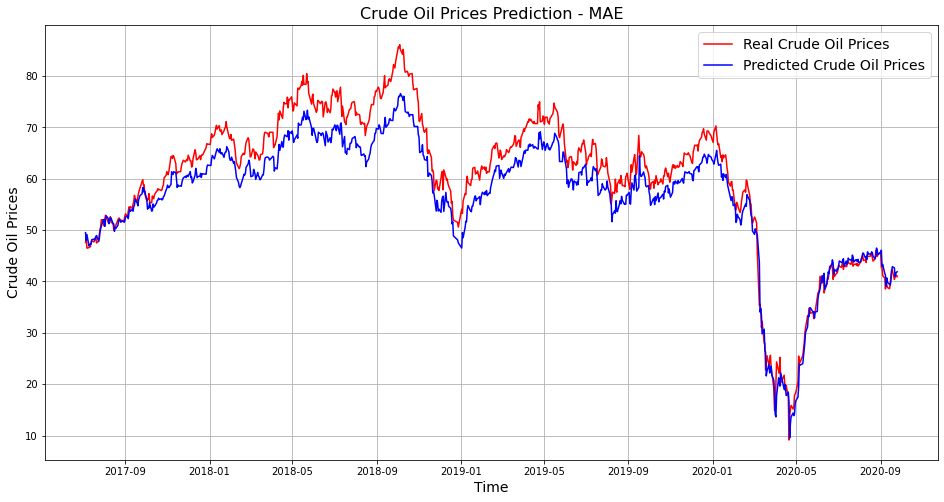

In [121]:
plt.figure(figsize=(16,8))
plt.plot(df.iloc[:,[0]], color = 'red', label = 'Real Crude Oil Prices')
plt.plot(df.iloc[:,[1]], color = 'blue', label = 'Predicted Crude Oil Prices')
plt.title('Crude Oil Prices Prediction - MAE',fontsize=16)
plt.xlabel('Time',fontsize=14)
plt.ylabel('Crude Oil Prices',fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

In [122]:
#MAE (mean absolut error)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(df.iloc[:,0].values, df.iloc[:,1].values)
print(mae)

3.7739241092802547


In [123]:
#MSE (mean sqared error)
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(df.iloc[:,0].values, df.iloc[:,1].values))
print(rmse)

4.427420014210376


#### Let's try to get 1st prediction from each set of prediction's

In [124]:
print(X_test_len)
print(timesteps)
print(predicted_test_mae_inv.shape)
print(df_data_1_test.shape)

y_predicted = []
for j in range(0, predicted_test_mae_inv.shape[0]):

    y_predicted = np.append(y_predicted, predicted_test_mae_inv[j, 0])

832
10
(832, 10)
(852, 1)


In [125]:
y_predicted = np.reshape(y_predicted, (y_predicted.shape[0], 1))
y_predicted.shape

(832, 1)

In [126]:
df = df_data_1_test.iloc[timesteps:X_test_len]
df['prediction'] = y_predicted[0:X_test_len-timesteps]
df.head()

<ipython-input-126-559566b15197>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = y_predicted[0:X_test_len-timesteps]


,DCOILBRENTEU,prediction
DATE,,
2017-07-05,47.58,46.044716
2017-07-06,48.53,45.897663
2017-07-07,46.47,45.602818
2017-07-10,46.57,45.556664
2017-07-11,46.68,47.456352


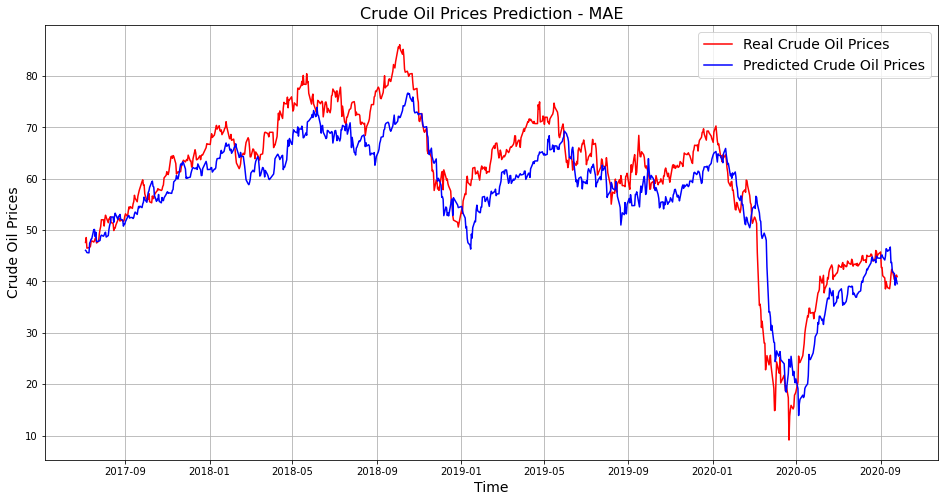

In [127]:
plt.figure(figsize=(16,8))
plt.plot(df.iloc[:,[0]], color = 'red', label = 'Real Crude Oil Prices')
plt.plot(df.iloc[:,[1]], color = 'blue', label = 'Predicted Crude Oil Prices')
plt.title('Crude Oil Prices Prediction - MAE',fontsize=16)
plt.xlabel('Time',fontsize=14)
plt.ylabel('Crude Oil Prices',fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

- We can see that we get predicted values with lag in this case

In [129]:
#MAE (mean absolut error)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(df.iloc[:,0].values, df.iloc[:,1].values)
print(mae)

5.039057126567311


In [130]:
#MSE (mean sqared error)
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(df.iloc[:,0].values, df.iloc[:,1].values))
print(rmse)

6.1558542348868945


#### Let's try have a look on first predictions

#### Variant 1

- take last value from prediction

In [131]:
print(X_test_len)
print(timesteps)
print(predicted_test_mae_inv.shape)
print(df_data_1_test.shape)

y_predicted = []
for j in range(0, predicted_test_mae_inv.shape[0]):

    y_predicted = np.append(y_predicted, predicted_test_mae_inv[j, timesteps-1])

832
10
(832, 10)
(852, 1)


#### Add prediction to df_data_1_test without cutting firts X_test samples and last X_test samples (keep NaN values)

In [133]:
ind = df_data_1_test.iloc[timesteps:X_test_len].index

In [134]:
df = df_data_1_test
df.loc[ind,'prediction'] = y_predicted[0:X_test_len-timesteps].reshape(822)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(new_indexer, value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [135]:
df

,DCOILBRENTEU,prediction
DATE,,
2017-06-21,44.62,NaN
2017-06-22,44.46,NaN
2017-06-23,44.14,NaN
2017-06-26,44.09,NaN
2017-06-27,46.17,NaN
...,...,...
2020-10-19,41.29,NaN
2020-10-20,41.62,NaN
2020-10-21,40.09,NaN


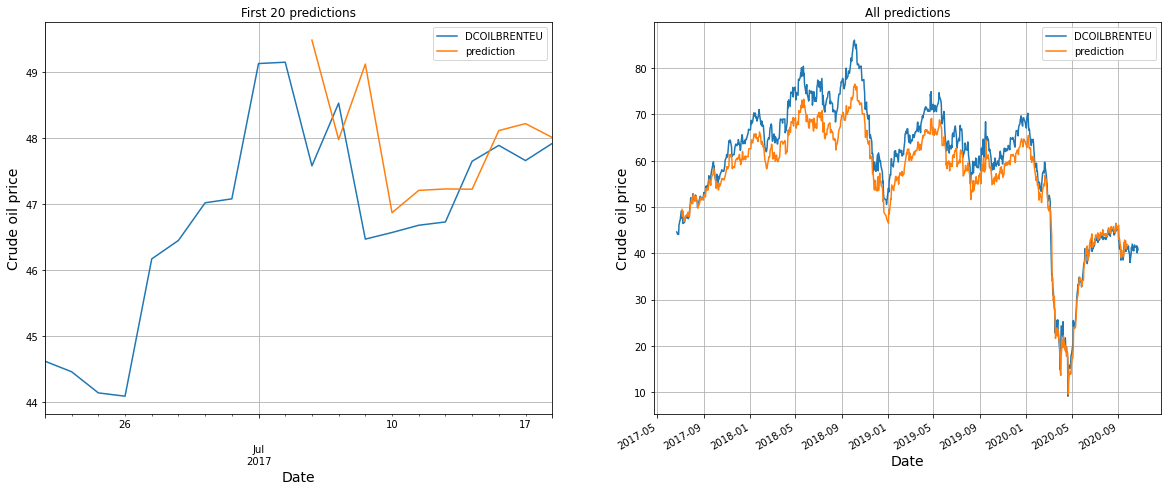

In [156]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
df[:20].plot(ax=axes[0])
df.plot(ax=axes[1])
axes[0].set_title('First 20 predictions')
axes[1].set_title('All predictions')
for i in range(2):
    axes[i].set_xlabel('Date', fontsize=14)
    axes[i].set_ylabel('Crude oil price', fontsize=14)
    axes[i].grid()

In [137]:
regressor_mae.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(64, 10, 1)]             0         
_________________________________________________________________
lstm_4 (LSTM)                (64, 10, 10)              480       
_________________________________________________________________
lstm_5 (LSTM)                (64, 10, 10)              840       
_________________________________________________________________
dense_2 (Dense)              (64, 10, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


#### As i understand we have next picture:
    
- trained model gets firrst 10 X_test samples 
- model provides 10 prediction to the future
- we cut first 10 samples and set for 11th sample last prediction from first set of predictions which should be tied with 20th sample - it seems strange, probably I interpretate something wrong

#### First 10 samples from X_test

In [375]:
df['DCOILBRENTEU'][:10]

DATE
2017-06-21    44.62
2017-06-22    44.46
2017-06-23    44.14
2017-06-26    44.09
2017-06-27    46.17
2017-06-28    46.45
2017-06-29    47.02
2017-06-30    47.08
2017-07-03    49.13
2017-07-04    49.15
Name: DCOILBRENTEU, dtype: float64

#### First 10 samples y_test

In [376]:
df['DCOILBRENTEU'][10:20]

DATE
2017-07-05    47.58
2017-07-06    48.53
2017-07-07    46.47
2017-07-10    46.57
2017-07-11    46.68
2017-07-12    46.73
2017-07-13    47.65
2017-07-14    47.89
2017-07-17    47.66
2017-07-18    47.92
Name: DCOILBRENTEU, dtype: float64

#### First 10 predictions

In [377]:
predicted_test_mae_inv[0]

array([46.044716, 44.4669  , 45.054222, 45.22505 , 47.441727, 47.596363,
       48.155663, 48.0491  , 49.931885, 49.4848  ], dtype=float32)